# Time series, sequences and predictions
Daily Min Temperature

## Importing Module

In [1]:
import os
import csv
import urllib

import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('seaborn')
print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.8.2


## Problem

- Build and train a neural network model using the Daily Min Temperature.csv dataset.
- Use `MAE` as the metrics of your neural network model.
- We provided code for normalizing the data. Please do not change the code.
- Do not use lambda layers in your model.
- The dataset used in this problem is downloaded from https://github.com/jbrownlee/Datasets
- Desired MAE < `0.19` on the normalized dataset.

### Preparing data

In [2]:
data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
name_file = 'daily-min-temperatures.csv'

if os.path.isfile(name_file) == False:
  urllib.request.urlretrieve(data_url, name_file)
  print(f'{name_file} Downloaded')
else:
  print(f'{name_file} Already exist')

daily-min-temperatures.csv Downloaded


#### Explore data

Load data using pandas

In [3]:
df = pd.read_csv(name_file)

In [4]:
print(f'Total Data : {df.shape[0]}')
print(f'Total Columns : {df.shape[1]}')

Total Data : 3650
Total Columns : 2


First 10 from data

In [5]:
df.head(10)

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
5,1981-01-06,15.8
6,1981-01-07,15.8
7,1981-01-08,17.4
8,1981-01-09,21.8
9,1981-01-10,20.0


More information about data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [7]:
df.columns = ['date', 'temperature'] # rename column

Visualize data

In [8]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

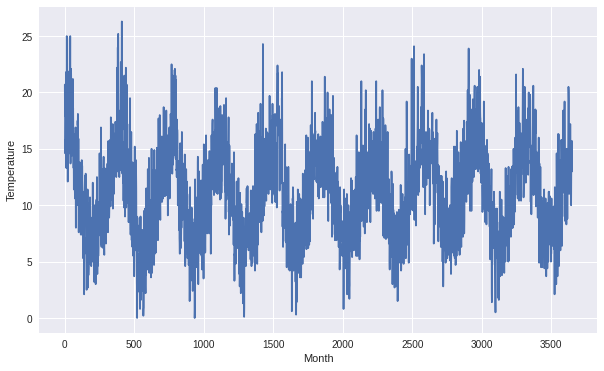

In [9]:
x = df.index
y = df['temperature']

plot_series(x, y, xlabel='Month', ylabel='Temperature')

### Preparing Model

Set Paramters

In [10]:
window_size=64
batch_size=256
shuffle_buffer_size=1000
split_time=2500

Prepare Feature and label (time from index series from montly_mean)

In [11]:
time = np.array(df.index)
series = np.array(df['temperature'])

Normalization Data

In [12]:
min = np.min(series)
max = np.max(series)
series -= min
series /= max

Fixed Partition

In [13]:
# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

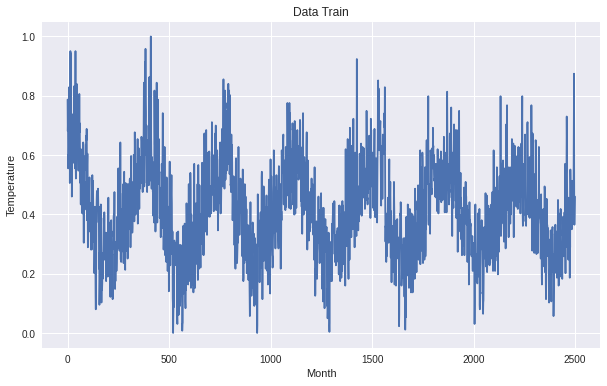

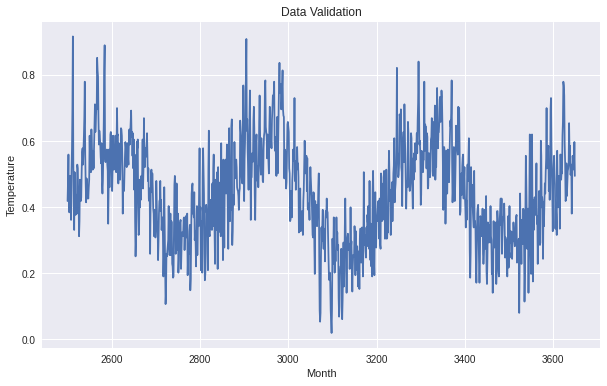

In [14]:
plot_series(time_train, x_train, 
            xlabel='Month', ylabel='Temperature', 
            title='Data Train')
plot_series(time_valid, x_valid, 
            xlabel='Month', ylabel='Temperature',
            title='Data Validation')

Windowing Data

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [16]:
train_set=windowed_dataset(x_train, window_size=window_size,
                           batch_size=batch_size, 
                           shuffle_buffer=shuffle_buffer_size)

#### Build Model

In [17]:
def build_model(WINDOW_SIZE, lr=1e-8):
  """
  Creates a model with learning rate schedule 
  for finding best learning rate
  
  Args:
      WINDOW_SIZE (int): the number of time steps to include in the feature
      lr (float): the number of learning rate optimizer

  Returns:
      model (tf.keras Model): the time, series model
  """

  # Define Params  
  adam = tf.keras.optimizers.Adam(learning_rate=lr) # Optimizer
  losses = tf.keras.losses.Huber()

  # Define Activation Function
  relu = tf.nn.relu

  # Define model sequential
  model = tf.keras.Sequential()

  # Define Convolutional 1D
  model.add(tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation=relu,
                      input_shape=[WINDOW_SIZE, 1]))
  
  # Define layers LSTM
  model.add(tf.keras.layers.LSTM(64, return_sequences=True))
  model.add(tf.keras.layers.LSTM(64))

  # Define Fully Connected layers
  model.add(tf.keras.layers.Dense(10, activation=relu))
  model.add(tf.keras.layers.Dense(10, activation=relu))
  model.add(tf.keras.layers.Dense(1))


  # Compile model
  model.compile(optimizer=adam, loss=losses, metrics=['mae'])

  # Check Summary Model
  model.summary()

  print('\nModel Succesfully Create')
  
  return model

#### Define Callbacks

In [18]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5", 
                                                      monitor="mae",
                                                      save_best_only=True,
                                                      verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="mae", 
                                                  patience=10, 
                                                  mode ="min", 
                                                  verbose=2, 
                                                  restore_best_weights=True)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

### Train Model

#### Train model with learning rate schedule

In [19]:
model = build_model(window_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 64, 60)            360       
                                                                 
 lstm (LSTM)                 (None, 64, 64)            32000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 66,155
Trainable params: 66,155
Non-traina

In [20]:
history_lr = model.fit(train_set ,epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 20s 70ms/step - loss: 0.0866 - mae: 0.3892 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 30ms/step - loss: 0.0866 - mae: 0.3892 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 28ms/step - loss: 0.0866 - mae: 0.3892 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 28ms/step - loss: 0.0866 - mae: 0.3892 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 26ms/step - loss: 0.0866 - mae: 0.3892 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 26ms/step - loss: 0.0866 - mae: 0.3892 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 28ms/step - loss: 0.0866 - mae: 0.3892 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 29ms/step - loss: 0.0866 - mae: 0.3892 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 0s 26ms/step - loss: 0.0866 - mae: 0.3892 - lr: 2.

Plot result of learning rate schedule

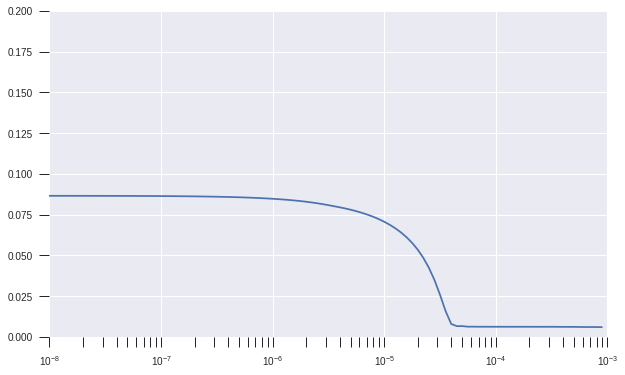

In [21]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history_lr.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, .2])
plt.show()

#### Train model with learning rate 1e-4

In [25]:
model = build_model(window_size, lr=1e-4)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 64, 60)            360       
                                                                 
 lstm_2 (LSTM)               (None, 64, 64)            32000     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 66,155
Trainable params: 66,155
Non-trai

In [26]:
history = model.fit(train_set,
                    epochs=100, 
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
      8/Unknown - 3s 29ms/step - loss: 0.0898 - mae: 0.3961
Epoch 1: mae improved from inf to 0.39206, saving model to model.h5
10/10 [==============================] - 3s 34ms/step - loss: 0.0880 - mae: 0.3921
Epoch 2/100
 8/10 [=======================>......] - ETA: 0s - loss: 0.0780 - mae: 0.3673
Epoch 2: mae improved from 0.39206 to 0.36519, saving model to model.h5
10/10 [==============================] - 0s 32ms/step - loss: 0.0772 - mae: 0.3652
Epoch 3/100
 8/10 [=======================>......] - ETA: 0s - loss: 0.0659 - mae: 0.3341
Epoch 3: mae improved from 0.36519 to 0.33241, saving model to model.h5
10/10 [==============================] - 0s 32ms/step - loss: 0.0651 - mae: 0.3324
Epoch 4/100
 8/10 [=======================>......] - ETA: 0s - loss: 0.0521 - mae: 0.2929
Epoch 4: mae improved from 0.33241 to 0.28724, saving model to model.h5
10/10 [==============================] - 0s 32ms/step - loss: 0.0503 - mae: 0.2872
Epoch 5/100
 8/10 [=======================

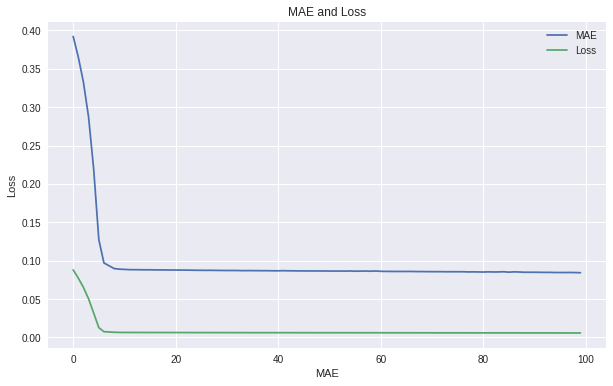

In [27]:
mae = history.history['mae']
loss = history.history['loss']
epochs=range(len(loss)) 

plot_series(x=epochs,
            y=(mae, loss), 
            title='MAE and Loss', 
            xlabel='MAE',
            ylabel='Loss',
            legend=['MAE', 'Loss'])

### Model Prediction

In [28]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

<Figure size 720x432 with 0 Axes>

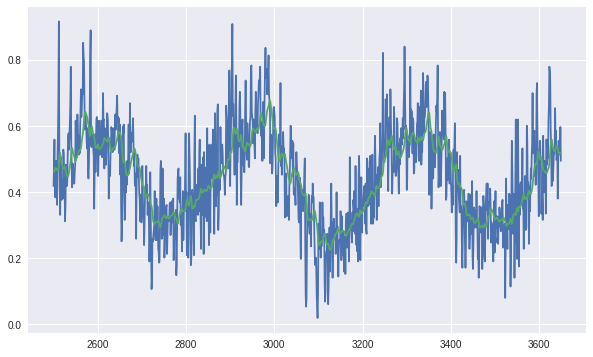

In [29]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, series, window_size).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[split_time - window_size:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, (x_valid,rnn_forecast))

In [30]:
# Compute the MAE
print(f'MAE: {tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()}')

MAE: 0.07762008905410767


### Download Model

In [ ]:
from google.colab import files
files.download('model.h5')